In [ ]:
!pip install -Uq gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.9 MB/s eta 0:00:00


In [ ]:
import tqdm
import math
import torch
import numpy as np

import torch.distributions as dist

import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

In [142]:
import math
from numbers import Number, Real

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all


class CensoredNormal(ExponentialFamily):
    """
    Creates a censored normal (also called Gaussian) distribution parameterized by
    :attr:`loc` and :attr:`scale` and :attr:`low`  and :attr:`high`

    Example::

        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> m = CensoredNormal(
          torch.tensor([0.0]), torch.tensor([1.0]),
          torch.tensor([-0.5]), torch.tensor([0.5])
          )
        >>> m.sample(sample_shape=(3,1))
        tensor([[0.5000],
            [0.5000],
            [0.1836]])
        tensor([ 0.1046])

    Args:
        loc (float or Tensor): mean of the base normal distribution (often referred to as mu) to which the censoring is applied
        scale (float or Tensor): standard deviation of the base normal distribution to which the censoring is applied
        low (float or Tensor): lower censoring boundary
        high (float or Tensor): upper censoring boundary
    """
    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "low": constraints.dependent(is_discrete=False, event_dim=0),
        "high": constraints.dependent(is_discrete=False, event_dim=0)}
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
        x_high = (self.high - self.loc)/self.scale
        cdf_high = self._normal_cdf(self.high)
        pdf_high = math.exp(self._normal_log_prob(self.high))
        x_low = (self.low - self.loc)/self.scale
        cdf_low = self._normal_cdf(self.low)
        pdf_low = math.exp(self._normal_log_prob(self.low))
        term1 = cdf_high - cdf_low
        term2 = pdf_high - pdf_low
        return self.loc * term1 - self.scale * term2

    @property
    def stddev(self):
        return self.variance.sqrt()

    @property
    def variance(self):
        x_high = (self.high - self.loc)/self.scale
        cdf_high = self._normal_cdf(self.high)
        pdf_high = math.exp(self._normal_log_prob(self.high))
        x_low = (self.low - self.loc)/self.scale
        cdf_low = self._normal_cdf(self.low)
        pdf_low = math.exp(self._normal_log_prob(self.low))
        term1 = cdf_high - cdf_low
        term2 = x_high * pdf_high - x_low * pdf_low
        return  (self.scale ** 2) * (term1 - term2)


    def __init__(self, loc, scale, low, high, validate_args=None):
        self.loc, self.scale, self.low, self.high = broadcast_all(loc, scale, low, high)
        if isinstance(loc, Number) and isinstance(scale, Number) and isinstance(low, Number) and isinstance(high, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        support = constraints.interval(low, high)
        super().__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(CensoredNormal, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        new.low = self.low.expand(batch_shape)
        new.high = self.high.expand(batch_shape)
        super(CensoredNormal, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    @constraints.dependent_property(is_discrete=False, event_dim=0)
    def support(self):
        return constraints.interval(self.low, self.high)


    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            samples = torch.normal(self.loc.expand(shape), self.scale.expand(shape))
            return samples.clamp(min=self.low, max=self.high)


    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        rsamples =  self.loc + eps * self.scale
        return rsamples.clamp(min=self.low, max=self.high)

    def pdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        probs = torch.exp(self.log_prob(value))
        lower_cdf_mass = self._normal_cdf(self.low)
        upper_cdf_mass = 1 - self._normal_cdf(self.high)
        probs = torch.where(value <= self.low, lower_cdf_mass, probs)
        probs = torch.where(value >= self.high, upper_cdf_mass, probs)
        return probs

    def log_prob(self, value, jitter=1e-12):
        """jitter: used to bounce off NormCDF from 0 before applying log """
        if self._validate_args:
            self._validate_sample(value)
        log_probs = self._normal_log_prob(value)
        lower_log_cdf_mass = math.log(self._normal_cdf(self.low) + jitter) if isinstance(self._normal_cdf(self.low) + jitter,
                                                                                                Number) else (self._normal_cdf(self.low) + jitter).log()
        upper_log_cdf_mass = math.log(1 - self._normal_cdf(self.high) + jitter) if isinstance(1 - self._normal_cdf(self.high) + jitter,
                                                                                                    Number) else (1 - self._normal_cdf(self.high) + jitter).log()
        log_probs = torch.where(value <= self.low, lower_log_cdf_mass, log_probs)
        log_probs = torch.where(value >= self.high, upper_log_cdf_mass, log_probs)
        return log_probs

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        cdf_ = self._normal_cdf(value)
        cdf_ = torch.where(value < self.low, 0, cdf_)
        cdf_ = torch.where(value > self.high, 1, cdf_)
        return cdf_

    def icdf(self, value):
        result = self._normal_icdf(value)
        return result.clamp(min=self.low, max=self.high)

    def entropy(self, jitter=1e-12):
        x_low = (self.low - self.loc)/self.scale
        x_high = (self.high - self.loc)/self.scale

        logcdf_x_low = math.log(self._normal_cdf(self.low) + jitter) if isinstance(self._normal_cdf(self.low) + jitter,
                                                                                                  Number) else (self._normal_cdf(self.low) + jitter).log()
        logcdf_x_high = math.log(self._normal_cdf_standardized(-x_high) + jitter) if isinstance(self._normal_cdf_standardized(x_high) + jitter,
                                                                                                      Number) else (self._normal_cdf_standardized(-x_high) + jitter).log()

        term1 = self._normal_entropy() * (self._normal_cdf(self.high)- self._normal_cdf(self.low))
        term2 = 0.5 * (x_high * torch.exp(self._normal_log_prob(self.high)) - x_low * torch.exp(self._normal_log_prob(self.low)))
        term3 = logcdf_x_low * self._normal_cdf(self.low)
        term4 = logcdf_x_high * (self._normal_cdf_standardized(-x_high))
        return term1 - term2 - term3 - term4


    def _normal_log_prob(self, value):
            # compute the variance
            var = self.scale**2
            log_scale = (
                math.log(self.scale) if isinstance(self.scale, Real) else self.scale.log()
            )
            return (
                -((value - self.loc) ** 2) / (2 * var)
                - log_scale
                - math.log(math.sqrt(2 * math.pi))
            )

    def _normal_cdf(self, value):
        return 0.5 * (
            1 + torch.erf((value - self.loc) * self.scale.reciprocal() / math.sqrt(2))
        )

    def _normal_cdf_standardized(self, z):
        return 0.5 * (
            1 + torch.erf(z / math.sqrt(2))
        )

    def _normal_icdf(self, value):
        return self.loc + self.scale * torch.erfinv(2 * value - 1) * math.sqrt(2)


    def _normal_entropy(self):\
        # log(sqrt(2 pi e) * sigma) = 0.5 * log(2 pi e) + log(sigma) = 0.5 + 0.5 (log(2 pi)) + log(sigma)
        return 0.5 + 0.5 * math.log(2 * math.pi) + torch.log(self.scale)

    @property
    def _normal_natural_params(self):
        return (self.loc / self.scale.pow(2), -0.5 * self.scale.pow(2).reciprocal())

    def _log_normalizer(self, x, y):
        return -0.25 * x.pow(2) / y + 0.5 * torch.log(-math.pi / y)

In [251]:
import warnings
from typing import Any

import torch
from linear_operator.operators import LinearOperator, ZeroLinearOperator
from torch import Tensor
from torch.distributions import Distribution, Normal

from gpytorch.constraints import Interval
from gpytorch.distributions import base_distributions, MultivariateNormal
from gpytorch.priors import Prior
from gpytorch.utils.warnings import GPInputWarning
from gpytorch.likelihoods.likelihood import _Likelihood, _OneDimensionalLikelihood


class CensoredGaussianLikelihood(_Likelihood):
    """Base class for Censored Gaussian Likelihoods."""
    def __init__(self, variance=None, low=None, high=None) -> None:
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.noise = gpytorch.likelihoods.noise_models.HomoskedasticNoise()
        self.noise.initialize(noise=variance)
        self.low = low
        self.high = high

    @property
    def variance(self):
      return self.noise.noise

    def forward(self, function_samples: Tensor, *params: Any, **kwargs: Any):
        return CensoredNormal(function_samples, scale=self.variance.sqrt(), low=self.low, high=self.high)

class CensoredGaussianLikelihoodMathematica(CensoredGaussianLikelihood):
    def __init__(self, variance=None, low=None, high=None) -> None:
        super().__init__(variance, low, high)

    def expected_log_prob(self, target: Tensor, input: MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
        noise = self.variance # likelihood
        mean, variance = input.mean, input.variance # approximate posterior

        jitter_=1e-16

        upper_censor = lambda x, s: (self.high - x) / s
        lower_censor = lambda x, s: (self.low - x) / s

        standard_normal = dist.Normal(0,1)
         # Gaussian term
        term1 = 2. + torch.log(noise) + math.log(2 * math.pi)
        term2 = ((target - mean).square() + variance) * noise.reciprocal()
        term3 = standard_normal.cdf(upper_censor(mean, variance.sqrt())) - standard_normal.cdf(lower_censor(mean, variance.sqrt()))
        normal_part_unscaled = (term1 - term2).mul(0.5)
        normal_part = normal_part_unscaled * term3

        # upper term
        x1 = (self.high - 2*target + mean) * variance.sqrt()
        term4 = torch.clamp_min(standard_normal.cdf(-upper_censor(target, variance.sqrt())), jitter_).log() + 0.5 * x1 * noise.reciprocal()
        upper_censored_part = term4 * standard_normal.log_prob(upper_censor(mean, variance.sqrt())).exp()

        # lower term
        x2 = (self.low - 2*target + mean) * variance.sqrt()
        term5 = torch.clamp_min(standard_normal.cdf(lower_censor(target, variance.sqrt())), jitter_).log() - 0.5 * x2 * noise.reciprocal()
        lower_censored_part = term5 * standard_normal.log_prob(lower_censor(mean, variance.sqrt())).exp()

        res = normal_part - lower_censored_part - upper_censored_part
        return res

class CensoredGaussianLikelihoodAnalytic(CensoredGaussianLikelihood):
    def __init__(self, variance=None, low=None, high=None) -> None:
        super().__init__(variance, low, high)

    def expected_log_prob(self, target: Tensor, input: MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
        noise = self.variance # likelihood
        mean, variance = input.mean, input.variance # approximate posterior

        jitter_=1e-16

        upper_censor = lambda x, s: (self.high - x) / s
        lower_censor = lambda x, s: (self.low - x) / s

        standard_normal = dist.Normal(0,1)
         # Gaussian term
        term1 = torch.log(noise) + math.log(2 * math.pi)
        term2 = ((target - mean).square() + variance) * noise.reciprocal()
        term3 = standard_normal.cdf(upper_censor(mean, variance.sqrt())) - standard_normal.cdf(lower_censor(mean, variance.sqrt()))
        normal_part_unscaled = (term1 - term2).mul(0.5)
        normal_part = normal_part_unscaled * term3

        # upper term
        x1 = (self.high - 2*target + mean) * variance.sqrt()
        term4 = torch.clamp_min(standard_normal.cdf(-upper_censor(target, variance.sqrt())), jitter_).log() + 0.5 * x1 * noise.reciprocal()
        upper_censored_part = term4 * standard_normal.log_prob(upper_censor(mean, variance.sqrt())).exp()

        # lower term
        x2 = (self.low - 2*target + mean) * variance.sqrt()
        term5 = torch.clamp_min(standard_normal.cdf(lower_censor(target, variance.sqrt())), jitter_).log() - 0.5 * x2 * noise.reciprocal()
        lower_censored_part = term5 * standard_normal.log_prob(lower_censor(mean, variance.sqrt())).exp()

        res = normal_part - lower_censored_part - upper_censored_part
        return res

In [252]:
print('\nMathematica:')
print(torch.as_tensor([
    CensoredGaussianLikelihoodMathematica(variance=1,low=-1,high=1).expected_log_prob(
        y[None],
        MultivariateNormal(y[None], torch.diag(torch.ones(1)))
    )
    for y in torch.as_tensor([-1, -0.5, 0, 0.5, 1])
]).numpy(force=True).round(6))

print('\nAnalytic:')
print(torch.as_tensor([
    CensoredGaussianLikelihoodAnalytic(variance=1,low=-1,high=1).expected_log_prob(
        y[None],
        MultivariateNormal(y[None], torch.diag(torch.ones(1)))
    )
    for y in torch.as_tensor([-1, -0.5, 0, 0.5, 1])
]).numpy(force=True).round(6))

print('\nAnalytic - Mathematica:')
print(torch.as_tensor([
    CensoredGaussianLikelihoodAnalytic(variance=1,low=-1,high=1).expected_log_prob(
        y[None],
        MultivariateNormal(y[None], torch.diag(torch.ones(1)))
    )
    for y in torch.as_tensor([-1, -0.5, 0, 0.5, 1])
]).numpy(force=True).round(6) - np.array([1.103980, 1.465660, 1.617670, 1.465660, 1.103980]))


Mathematica:
[1.103981 1.465658 1.61767  1.465658 1.103981]

Analytic:
[0.626731 0.841003 0.934981 0.841003 0.626731]

Analytic - Mathematica:
[-0.47724902 -0.624657   -0.68268901 -0.624657   -0.47724902]


In [238]:
for y_i in torch.linspace(-1., 1., 10):
    print('y',y_i)
    lik_i = CensoredGaussianLikelihoodAnalytic(0.1,y_i,y_i+1)
    print('lik',(0.1,y_i,y_i+1))
    f_i = MultivariateNormal(y_i[None], torch.diag(torch.ones(1)))
    print('f',f_i)
    print(lik_i.expected_log_prob(y_i[None],f_i))
    print('='*40)

y tensor(-1.)
lik (0.1, tensor(-1.), tensor(0.))
f MultivariateNormal(loc: tensor([-1.]), covariance_matrix: tensor([[1.]]))
tensor([-2.2739], grad_fn=<SubBackward0>)
y tensor(-0.7778)
lik (0.1, tensor(-0.7778), tensor(0.2222))
f MultivariateNormal(loc: tensor([-0.7778]), covariance_matrix: tensor([[1.]]))
tensor([-2.2739], grad_fn=<SubBackward0>)
y tensor(-0.5556)
lik (0.1, tensor(-0.5556), tensor(0.4444))
f MultivariateNormal(loc: tensor([-0.5556]), covariance_matrix: tensor([[1.]]))
tensor([-2.2739], grad_fn=<SubBackward0>)
y tensor(-0.3333)
lik (0.1, tensor(-0.3333), tensor(0.6667))
f MultivariateNormal(loc: tensor([-0.3333]), covariance_matrix: tensor([[1.]]))
tensor([-2.2739], grad_fn=<SubBackward0>)
y tensor(-0.1111)
lik (0.1, tensor(-0.1111), tensor(0.8889))
f MultivariateNormal(loc: tensor([-0.1111]), covariance_matrix: tensor([[1.]]))
tensor([-2.2739], grad_fn=<SubBackward0>)
y tensor(0.1111)
lik (0.1, tensor(0.1111), tensor(1.1111))
f MultivariateNormal(loc: tensor([0.1111])

In [239]:
def rgetattr(o, k_list):
  for k in k_list:
    o = getattr(o,k)
  return o

def print_module(module):
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      print(f'{name:35} {tuple(param.shape)}\n{param.numpy().round(10)}')

def get_module(module):
  ret = {}
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      ret[name] = param.numpy()
  return ret

# Synthetic 1D

In [224]:
MAX_VALUE = 0.0

def noise_free_target(x):
    y = (x-2)*10
    return y * torch.sin(y) / 2

def oracle(x):
    return torch.clamp_max(noise_free_target(x) + torch.randn(x.shape) , 0.0)

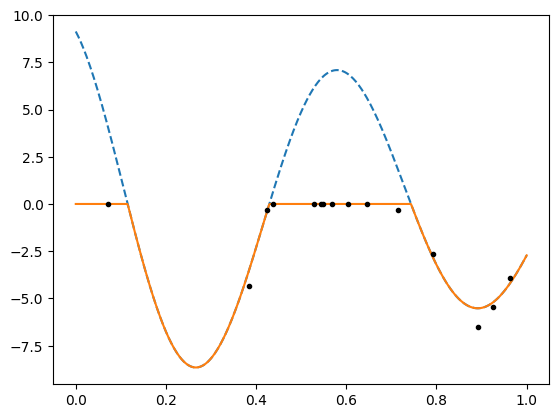

In [225]:
N_init = 15
np.random.seed(0)
x = torch.FloatTensor(np.random.rand(N_init))
torch.sort(x)
y = oracle(x)

domain = torch.linspace(0, 1, 500)
plt.plot(domain, noise_free_target(domain), '--');
plt.plot(domain, torch.clamp_max(noise_free_target(domain), 0), '-');
plt.plot(x, y, 'k.')

# ELBO Implementation

In [240]:
from gpytorch.models import ApproximateGP # handles basic variational inference
from gpytorch.variational import CholeskyVariationalDistribution # distribution of the approximation q(f)
from gpytorch.variational import VariationalStrategy # use when larger sample - transform q(u) to q(f) over inducing points

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        # defines approximation
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points,
                                                   variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # defines the GP
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = GPModel(inducing_points=x[:,None])
likelihood = CensoredGaussianLikelihoodAnalytic(low=-100., high=MAX_VALUE)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [241]:
model.covar_module.base_kernel.initialize(lengthscale=0.5)
model.covar_module.initialize(outputscale=5);
model.mean_module.initialize(constant=0.1)
likelihood.noise.initialize(noise=.5);

In [242]:
print_module(likelihood)
print_module(model)

noise.noise                         (1,)
[0.49999994]
variational_strategy._variational_distribution.variational_mean (15,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
variational_strategy._variational_distribution.chol_variational_covar (15, 15)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
mean_module.constant         

In [245]:
num_epochs = 20_000
pbar = tqdm.tqdm(range(num_epochs), position=0, leave=True)

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.001)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

params_log = dict()
for iter in pbar:
    optimizer.zero_grad();
    y_pred = model(x[:,None])
    loss = -mll(y_pred, y)
    loss.backward()
    optimizer.step()
    param_log[iter] = {
        'loss': loss.item(),
        'outscale': model.covar_module.outputscale.item(),
        'mean_module': model.mean_module.constant.item(),
        'noise': likelihood.noise.noise.item()
        }

    if iter%100==0:
      for key, val in param_log[iter].items():
        print(key, val)

  0%|          | 20/20000 [00:00<03:33, 93.72it/s]

loss -0.1829809546470642
outscale 4.617129802703857
mean_module 0.05851111561059952
noise 0.6546681523323059


  1%|          | 109/20000 [00:01<05:39, 58.64it/s]

loss -1.6538199186325073
outscale 4.519364833831787
mean_module 0.028847884386777878
noise 0.7022887468338013


  1%|          | 207/20000 [00:03<05:43, 57.70it/s]

loss -2.12290096282959
outscale 4.455609321594238
mean_module 0.014229019172489643
noise 0.748451828956604


  2%|▏         | 317/20000 [00:04<03:49, 85.64it/s]

loss -2.865480899810791
outscale 4.412744998931885
mean_module 0.013636047020554543
noise 0.794700026512146


  2%|▏         | 417/20000 [00:05<03:32, 92.34it/s]

loss -3.05292010307312
outscale 4.371828079223633
mean_module 0.0086263632401824
noise 0.8412878513336182


  3%|▎         | 511/20000 [00:07<04:50, 67.20it/s]

loss -3.215165615081787
outscale 4.332889556884766
mean_module 0.0025912451092153788
noise 0.8883125185966492


  3%|▎         | 610/20000 [00:08<05:06, 63.18it/s]

loss -3.360915422439575
outscale 4.295382976531982
mean_module -0.0036116663832217455
noise 0.9358510375022888


  4%|▎         | 716/20000 [00:10<03:40, 87.41it/s]

loss -3.499683380126953
outscale 4.257944583892822
mean_module -0.009738387539982796
noise 0.9839527010917664


  4%|▍         | 814/20000 [00:11<03:34, 89.39it/s]

loss -3.682373285293579
outscale 4.215899467468262
mean_module -0.015598221682012081
noise 1.0325722694396973


  5%|▍         | 913/20000 [00:12<03:34, 88.93it/s]

loss -4.615475654602051
outscale 4.167793273925781
mean_module -0.013473504222929478
noise 1.0806500911712646


  5%|▌         | 1011/20000 [00:13<03:20, 94.94it/s]

loss -5.480659008026123
outscale 4.120007514953613
mean_module -0.007683712523430586
noise 1.1296652555465698


  6%|▌         | 1108/20000 [00:14<04:28, 70.37it/s]

loss -5.567956924438477
outscale 4.090256690979004
mean_module -0.00721919909119606
noise 1.1789100170135498


  6%|▌         | 1211/20000 [00:16<05:04, 61.72it/s]

loss -5.643444061279297
outscale 4.061012268066406
mean_module -0.00706460839137435
noise 1.2288185358047485


  7%|▋         | 1313/20000 [00:17<03:47, 82.10it/s]

loss -5.203963756561279
outscale 4.031274318695068
mean_module -0.0067205787636339664
noise 1.2794115543365479


  7%|▋         | 1412/20000 [00:18<03:32, 87.65it/s]

loss -5.777662754058838
outscale 4.000421524047852
mean_module -0.00691930390894413
noise 1.3306481838226318


  8%|▊         | 1510/20000 [00:19<03:19, 92.84it/s]

loss -5.841091632843018
outscale 3.9689507484436035
mean_module -0.0064410250633955
noise 1.3824673891067505


  8%|▊         | 1618/20000 [00:21<03:23, 90.23it/s]

loss -5.899316310882568
outscale 3.9363698959350586
mean_module -0.007121111731976271
noise 1.4348077774047852


  9%|▊         | 1714/20000 [00:22<03:29, 87.35it/s]

loss -5.441889762878418
outscale 3.902958869934082
mean_module -0.006782461889088154
noise 1.4876289367675781


  9%|▉         | 1815/20000 [00:23<03:15, 93.02it/s]

loss -5.500196933746338
outscale 3.868177890777588
mean_module -0.007280957885086536
noise 1.5408681631088257


 10%|▉         | 1915/20000 [00:24<03:10, 94.95it/s]

loss -6.061595916748047
outscale 3.832458734512329
mean_module -0.007148432079702616
noise 1.5944987535476685


 10%|█         | 2015/20000 [00:25<03:25, 87.53it/s]

loss -6.10963773727417
outscale 3.795449733734131
mean_module -0.0071677216328680515
noise 1.6484826803207397


 11%|█         | 2113/20000 [00:26<03:27, 86.20it/s]

loss -6.155845642089844
outscale 3.7574610710144043
mean_module -0.007048117462545633
noise 1.702791690826416


 11%|█         | 2208/20000 [00:27<04:25, 67.05it/s]

loss -5.684562683105469
outscale 3.718341827392578
mean_module -0.006928225979208946
noise 1.7574070692062378


 12%|█▏        | 2308/20000 [00:29<04:39, 63.28it/s]

loss -5.727395057678223
outscale 3.67781662940979
mean_module -0.0066421073861420155
noise 1.81230628490448


 12%|█▏        | 2412/20000 [00:30<03:40, 79.67it/s]

loss -6.281661510467529
outscale 3.6364548206329346
mean_module -0.007091036532074213
noise 1.8674688339233398


 13%|█▎        | 2515/20000 [00:31<03:08, 92.69it/s]

loss -6.320084571838379
outscale 3.5937490463256836
mean_module -0.006884951610118151
noise 1.922892689704895


 13%|█▎        | 2615/20000 [00:33<03:07, 92.71it/s]

loss -6.357935428619385
outscale 3.5506107807159424
mean_module -0.006861971691250801
noise 1.978562831878662


 14%|█▎        | 2715/20000 [00:34<03:11, 90.44it/s]

loss -6.392910480499268
outscale 3.505835771560669
mean_module -0.007037414237856865
noise 2.0344741344451904


 14%|█▍        | 2815/20000 [00:35<03:02, 94.03it/s]

loss -5.9173479080200195
outscale 3.460278272628784
mean_module -0.0073522585444152355
noise 2.0906271934509277


 15%|█▍        | 2916/20000 [00:36<03:04, 92.50it/s]

loss -6.460793972015381
outscale 3.413717746734619
mean_module -0.006721205543726683
noise 2.1470184326171875


 15%|█▌        | 3017/20000 [00:37<02:58, 94.96it/s]

loss -6.49196720123291
outscale 3.3660430908203125
mean_module -0.007059250958263874
noise 2.203636884689331


 16%|█▌        | 3117/20000 [00:38<03:04, 91.29it/s]

loss -6.5212016105651855
outscale 3.317288637161255
mean_module -0.0068713161163032055
noise 2.2604920864105225


 16%|█▌        | 3217/20000 [00:39<03:07, 89.41it/s]

loss -6.552323341369629
outscale 3.2684473991394043
mean_module -0.006790620274841785
noise 2.3175811767578125


 17%|█▋        | 3309/20000 [00:40<04:03, 68.46it/s]

loss -6.0671467781066895
outscale 3.2185680866241455
mean_module -0.0067533995024859905
noise 2.3749043941497803


 17%|█▋        | 3407/20000 [00:42<04:39, 59.30it/s]

loss -6.6086745262146
outscale 3.168111562728882
mean_module -0.006779822055250406
noise 2.4324660301208496


 18%|█▊        | 3514/20000 [00:43<03:04, 89.14it/s]

loss -6.6349406242370605
outscale 3.116870880126953
mean_module -0.006424473598599434
noise 2.4902732372283936


 18%|█▊        | 3612/20000 [00:44<02:53, 94.27it/s]

loss -6.661242485046387
outscale 3.0655245780944824
mean_module -0.006430980749428272
noise 2.5483219623565674


 19%|█▊        | 3712/20000 [00:46<03:00, 90.46it/s]

loss -6.686678409576416
outscale 3.013850212097168
mean_module -0.006293387617915869
noise 2.606621026992798


 19%|█▉        | 3811/20000 [00:47<02:51, 94.29it/s]

loss -6.202572345733643
outscale 2.961407423019409
mean_module -0.006146484520286322
noise 2.6651771068573


 20%|█▉        | 3911/20000 [00:48<03:00, 89.15it/s]

loss -6.735076904296875
outscale 2.9084842205047607
mean_module -0.005981320049613714
noise 2.7239925861358643


 20%|██        | 4017/20000 [00:49<03:00, 88.44it/s]

loss -6.757784366607666
outscale 2.8552284240722656
mean_module -0.005299987271428108
noise 2.7830724716186523


 21%|██        | 4117/20000 [00:50<02:55, 90.27it/s]

loss -6.780363082885742
outscale 2.802088737487793
mean_module -0.005655947141349316
noise 2.842416763305664


 21%|██        | 4217/20000 [00:51<02:50, 92.83it/s]

loss -6.286593437194824
outscale 2.747830390930176
mean_module -0.005237491335719824
noise 2.9020397663116455


 22%|██▏       | 4316/20000 [00:52<02:51, 91.52it/s]

loss -6.8244099617004395
outscale 2.6951324939727783
mean_module -0.005439172964543104
noise 2.9619271755218506


 22%|██▏       | 4409/20000 [00:53<03:44, 69.43it/s]

loss -6.845015525817871
outscale 2.641608476638794
mean_module -0.005001865793019533
noise 3.022116184234619


 23%|██▎       | 4508/20000 [00:55<04:26, 58.21it/s]

loss -6.348708629608154
outscale 2.58797550201416
mean_module -0.004360545426607132
noise 3.0825936794281006


 23%|██▎       | 4613/20000 [00:56<02:55, 87.92it/s]

loss -6.884432315826416
outscale 2.534111261367798
mean_module -0.004877891391515732
noise 3.1433513164520264


 24%|██▎       | 4713/20000 [00:57<02:46, 91.98it/s]

loss -6.903935432434082
outscale 2.48128604888916
mean_module -0.004007152281701565
noise 3.204416513442993


 24%|██▍       | 4813/20000 [00:59<02:44, 92.15it/s]

loss -6.920356750488281
outscale 2.427946090698242
mean_module -0.0049496605060994625
noise 3.2657673358917236


 25%|██▍       | 4913/20000 [01:00<02:38, 95.12it/s]

loss -6.939951419830322
outscale 2.3748250007629395
mean_module -0.003586627310141921
noise 3.327449083328247


 25%|██▌       | 5013/20000 [01:01<02:46, 90.23it/s]

loss -6.453826427459717
outscale 2.3242592811584473
mean_module -0.004247843753546476
noise 3.3894150257110596


 26%|██▌       | 5112/20000 [01:02<02:45, 89.82it/s]

loss -6.977767467498779
outscale 2.272545576095581
mean_module -0.003651689039543271
noise 3.4517130851745605


 26%|██▌       | 5216/20000 [01:03<02:44, 89.85it/s]

loss -6.99373722076416
outscale 2.220608949661255
mean_module -0.00291314790956676
noise 3.5143258571624756


 27%|██▋       | 5317/20000 [01:04<02:35, 94.66it/s]

loss -7.012003421783447
outscale 2.170091152191162
mean_module -0.003296752693131566
noise 3.577244520187378


 27%|██▋       | 5417/20000 [01:05<02:39, 91.65it/s]

loss -6.008632183074951
outscale 2.119765520095825
mean_module -0.0033484874293208122
noise 3.6404917240142822


 28%|██▊       | 5513/20000 [01:07<03:39, 66.04it/s]

loss -6.540960311889648
outscale 2.069221258163452
mean_module -0.0038597439415752888
noise 3.7040765285491943


 28%|██▊       | 5612/20000 [01:08<03:52, 61.86it/s]

loss -6.548635482788086
outscale 2.020026922225952
mean_module -0.0027287763077765703
noise 3.76798152923584


 29%|██▊       | 5711/20000 [01:10<03:11, 74.66it/s]

loss -7.076651573181152
outscale 1.9708774089813232
mean_module -0.0028134160675108433
noise 3.832231283187866


 29%|██▉       | 5814/20000 [01:11<02:51, 82.69it/s]

loss -7.090860366821289
outscale 1.9214164018630981
mean_module -0.0022566961124539375
noise 3.896815538406372


 30%|██▉       | 5914/20000 [01:12<02:29, 93.98it/s]

loss -6.603604316711426
outscale 1.8751155138015747
mean_module -0.0025953834410756826
noise 3.9617197513580322


 30%|███       | 6014/20000 [01:13<02:33, 91.24it/s]

loss -7.121878623962402
outscale 1.827392578125
mean_module -0.002191671170294285
noise 4.026987075805664


 31%|███       | 6115/20000 [01:14<02:31, 91.91it/s]

loss -7.136079788208008
outscale 1.7801239490509033
mean_module -0.0011844041291624308
noise 4.092587471008301


 31%|███       | 6216/20000 [01:15<02:26, 94.37it/s]

loss -7.150267124176025
outscale 1.7335065603256226
mean_module -0.0013998094946146011
noise 4.15852689743042


 32%|███▏      | 6314/20000 [01:17<04:20, 52.50it/s]

loss -7.164820671081543
outscale 1.6885626316070557
mean_module -0.0008633016841486096
noise 4.224812030792236


 32%|███▏      | 6417/20000 [01:18<02:36, 86.94it/s]

loss -7.17846155166626
outscale 1.6436450481414795
mean_module -0.0014513609930872917
noise 4.291442394256592


 33%|███▎      | 6508/20000 [01:19<02:55, 76.85it/s]

loss -7.190843105316162
outscale 1.5989174842834473
mean_module -0.0013962374068796635
noise 4.358432292938232


 33%|███▎      | 6608/20000 [01:21<04:17, 51.94it/s]

loss -7.2051239013671875
outscale 1.5546472072601318
mean_module -0.00044163261190988123
noise 4.425764083862305


 34%|███▎      | 6718/20000 [01:22<02:34, 85.71it/s]

loss -6.203628063201904
outscale 1.5116517543792725
mean_module -0.000217391163459979
noise 4.493435859680176


 34%|███▍      | 6819/20000 [01:23<02:21, 93.16it/s]

loss -6.721261978149414
outscale 1.4686849117279053
mean_module -0.00018728704890236259
noise 4.561461925506592


 35%|███▍      | 6918/20000 [01:24<02:26, 89.17it/s]

loss -7.244054794311523
outscale 1.4260286092758179
mean_module -5.019117088522762e-05
noise 4.629823684692383


 35%|███▌      | 7018/20000 [01:25<02:20, 92.22it/s]

loss -7.2575201988220215
outscale 1.3851512670516968
mean_module 0.0006429452914744616
noise 4.698544502258301


 36%|███▌      | 7119/20000 [01:26<02:12, 97.20it/s]

loss -7.2693610191345215
outscale 1.3449748754501343
mean_module 0.0006751493201591074
noise 4.767613887786865


 36%|███▌      | 7205/20000 [01:28<04:57, 42.95it/s]

loss -7.281922817230225
outscale 1.3055974245071411
mean_module 0.00152558833360672
noise 4.837033271789551


 36%|███▋      | 7300/20000 [01:30<05:36, 37.76it/s]

loss -7.293605804443359
outscale 1.2675821781158447
mean_module 0.000732088868971914
noise 4.9067769050598145


 37%|███▋      | 7414/20000 [01:34<03:14, 64.74it/s]

loss -7.305123805999756
outscale 1.229299783706665
mean_module 0.0008672467665746808
noise 4.9768829345703125


 38%|███▊      | 7506/20000 [01:35<03:29, 59.76it/s]

loss -7.316949844360352
outscale 1.192229986190796
mean_module 0.0009563743369653821
noise 5.047327041625977


 38%|███▊      | 7619/20000 [01:37<02:14, 92.34it/s]

loss -7.327536582946777
outscale 1.1555297374725342
mean_module 0.0012601427733898163
noise 5.118112564086914


 39%|███▊      | 7717/20000 [01:38<02:14, 91.60it/s]

loss -7.341146469116211
outscale 1.1197210550308228
mean_module 0.0024533893447369337
noise 5.18923282623291


 39%|███▉      | 7818/20000 [01:39<02:09, 93.94it/s]

loss -6.850635051727295
outscale 1.0850212574005127
mean_module 0.0020962355192750692
noise 5.260685920715332


 40%|███▉      | 7918/20000 [01:40<02:08, 94.05it/s]

loss -7.36370849609375
outscale 1.0507721900939941
mean_module 0.0032368595711886883
noise 5.332498073577881


 40%|████      | 8020/20000 [01:41<02:06, 94.43it/s]

loss -7.374695777893066
outscale 1.016878604888916
mean_module 0.0027172707486897707
noise 5.404628753662109


 41%|████      | 8111/20000 [01:42<02:07, 93.30it/s]

loss -7.384124279022217
outscale 0.98349529504776
mean_module 0.002798804547637701
noise 5.477089881896973


 41%|████      | 8211/20000 [01:43<02:04, 94.84it/s]

loss -7.3960795402526855
outscale 0.9519302845001221
mean_module 0.003283721162006259
noise 5.549882888793945


 42%|████▏     | 8313/20000 [01:44<02:00, 96.87it/s]

loss -7.406149387359619
outscale 0.9211747646331787
mean_module 0.004347141832113266
noise 5.623006343841553


 42%|████▏     | 8415/20000 [01:45<02:00, 96.34it/s]

loss -7.417383670806885
outscale 0.8916193842887878
mean_module 0.004109309986233711
noise 5.69644021987915


 43%|████▎     | 8512/20000 [01:46<02:47, 68.41it/s]

loss -7.4274444580078125
outscale 0.8621315956115723
mean_module 0.0038127959705889225
noise 5.770185470581055


 43%|████▎     | 8610/20000 [01:48<03:08, 60.40it/s]

loss -7.437500476837158
outscale 0.8333425521850586
mean_module 0.004122013226151466
noise 5.844266891479492


 44%|████▎     | 8713/20000 [01:49<02:01, 92.95it/s]

loss -7.4481964111328125
outscale 0.8054817914962769
mean_module 0.004634533543139696
noise 5.918668746948242


 44%|████▍     | 8814/20000 [01:50<01:58, 94.16it/s]

loss -7.457500457763672
outscale 0.7781047224998474
mean_module 0.0049157836474478245
noise 5.993380546569824


 45%|████▍     | 8915/20000 [01:51<01:58, 93.88it/s]

loss -7.467928886413574
outscale 0.7520931959152222
mean_module 0.005021735560148954
noise 6.068398475646973


 45%|████▌     | 9015/20000 [01:53<01:58, 92.39it/s]

loss -6.975772857666016
outscale 0.7265671491622925
mean_module 0.0056463852524757385
noise 6.143734455108643


 46%|████▌     | 9114/20000 [01:54<01:58, 92.20it/s]

loss -6.986093997955322
outscale 0.7013341784477234
mean_module 0.005213639233261347
noise 6.219341278076172


 46%|████▌     | 9214/20000 [01:55<01:54, 94.13it/s]

loss -7.496455669403076
outscale 0.6768015027046204
mean_module 0.006319253705441952
noise 6.295276641845703


 47%|████▋     | 9314/20000 [01:56<01:52, 94.95it/s]

loss -7.504924297332764
outscale 0.6538820862770081
mean_module 0.005530753172934055
noise 6.371483325958252


 47%|████▋     | 9414/20000 [01:57<01:57, 90.12it/s]

loss -7.013920783996582
outscale 0.6311014294624329
mean_module 0.006429354660212994
noise 6.448003768920898


 48%|████▊     | 9513/20000 [01:58<01:51, 93.74it/s]

loss -7.52445650100708
outscale 0.6091631054878235
mean_module 0.007440019864588976
noise 6.52481746673584


 48%|████▊     | 9610/20000 [01:59<02:28, 69.73it/s]

loss -7.533820152282715
outscale 0.5882841944694519
mean_module 0.007032671011984348
noise 6.601894378662109


 49%|████▊     | 9707/20000 [02:01<03:11, 53.87it/s]

loss -7.543020725250244
outscale 0.5680869817733765
mean_module 0.007759384345263243
noise 6.679266452789307


 49%|████▉     | 9812/20000 [02:02<01:56, 87.31it/s]

loss -7.551393508911133
outscale 0.5479509234428406
mean_module 0.007660876959562302
noise 6.756904602050781


 50%|████▉     | 9912/20000 [02:03<02:09, 77.85it/s]

loss -7.560502052307129
outscale 0.5291678309440613
mean_module 0.008565964177250862
noise 6.834819793701172


 50%|█████     | 10010/20000 [02:05<01:48, 92.01it/s]

loss -7.062543869018555
outscale 0.510836124420166
mean_module 0.00792520772665739
noise 6.9130144119262695


 51%|█████     | 10120/20000 [02:06<01:45, 93.52it/s]

loss -7.576606750488281
outscale 0.49295204877853394
mean_module 0.007779700681567192
noise 6.991465091705322


 51%|█████     | 10217/20000 [02:07<01:51, 87.66it/s]

loss -7.5855913162231445
outscale 0.4758026599884033
mean_module 0.008579134941101074
noise 7.070185661315918


 52%|█████▏    | 10311/20000 [02:08<01:48, 89.02it/s]

loss -7.091849327087402
outscale 0.4593193531036377
mean_module 0.009086652658879757
noise 7.1491522789001465


 52%|█████▏    | 10412/20000 [02:09<01:42, 93.61it/s]

loss -7.60259485244751
outscale 0.44334450364112854
mean_module 0.009824953973293304
noise 7.228382587432861


 53%|█████▎    | 10512/20000 [02:10<01:40, 94.75it/s]

loss -7.610637187957764
outscale 0.42810240387916565
mean_module 0.010220269672572613
noise 7.307852745056152


 53%|█████▎    | 10612/20000 [02:11<01:41, 92.49it/s]

loss -7.6170830726623535
outscale 0.4131397306919098
mean_module 0.008888976648449898
noise 7.387576580047607


 54%|█████▎    | 10708/20000 [02:12<02:16, 68.20it/s]

loss -7.626737117767334
outscale 0.39848676323890686
mean_module 0.010540462099015713
noise 7.467564582824707


 54%|█████▍    | 10807/20000 [02:14<02:34, 59.44it/s]

loss -7.634435176849365
outscale 0.3844946324825287
mean_module 0.01004616916179657
noise 7.547756195068359


 55%|█████▍    | 10914/20000 [02:15<01:44, 87.34it/s]

loss -7.642461776733398
outscale 0.37109142541885376
mean_module 0.010866649448871613
noise 7.62820291519165


 55%|█████▌    | 11016/20000 [02:17<01:44, 86.26it/s]

loss -7.649868488311768
outscale 0.3580572307109833
mean_module 0.01091375108808279
noise 7.708868026733398


 56%|█████▌    | 11112/20000 [02:18<01:36, 91.78it/s]

loss -7.153695583343506
outscale 0.34583136439323425
mean_module 0.01168551854789257
noise 7.789767742156982


 56%|█████▌    | 11219/20000 [02:19<01:38, 88.78it/s]

loss -7.665457248687744
outscale 0.3337310552597046
mean_module 0.011500200256705284
noise 7.870903015136719


 57%|█████▋    | 11314/20000 [02:20<01:39, 87.09it/s]

loss -7.167662620544434
outscale 0.32202109694480896
mean_module 0.011369297280907631
noise 7.952245235443115


 57%|█████▋    | 11415/20000 [02:21<01:33, 91.60it/s]

loss -7.6802077293396
outscale 0.3105941414833069
mean_module 0.011829536408185959
noise 8.033804893493652


 58%|█████▊    | 11516/20000 [02:22<01:32, 91.75it/s]

loss -7.687228202819824
outscale 0.29958221316337585
mean_module 0.01274945866316557
noise 8.11559009552002


 58%|█████▊    | 11617/20000 [02:23<01:28, 95.19it/s]

loss -7.1936445236206055
outscale 0.2892347574234009
mean_module 0.01203149650245905
noise 8.197574615478516


 59%|█████▊    | 11717/20000 [02:24<01:30, 91.20it/s]

loss -7.7016425132751465
outscale 0.2786848545074463
mean_module 0.012968749739229679
noise 8.279768943786621


 59%|█████▉    | 11812/20000 [02:26<02:01, 67.50it/s]

loss -7.708865642547607
outscale 0.26909786462783813
mean_module 0.01346162986010313
noise 8.362178802490234


 60%|█████▉    | 11908/20000 [02:27<02:20, 57.55it/s]

loss -7.716109752655029
outscale 0.25975000858306885
mean_module 0.013117372058331966
noise 8.444757461547852


 60%|██████    | 12015/20000 [02:29<01:32, 86.76it/s]

loss -7.72165060043335
outscale 0.25060659646987915
mean_module 0.012665982358157635
noise 8.52755069732666


 61%|██████    | 12115/20000 [02:30<01:24, 93.24it/s]

loss -7.225698471069336
outscale 0.24185428023338318
mean_module 0.01302347145974636
noise 8.61053466796875


 61%|██████    | 12215/20000 [02:31<01:26, 89.88it/s]

loss -7.736433982849121
outscale 0.2331753820180893
mean_module 0.01402183249592781
noise 8.69372272491455


 62%|██████▏   | 12311/20000 [02:32<01:24, 90.62it/s]

loss -7.743236541748047
outscale 0.2250361442565918
mean_module 0.014160651713609695
noise 8.777085304260254


 62%|██████▏   | 12408/20000 [02:33<01:27, 87.10it/s]

loss -7.750161170959473
outscale 0.21740348637104034
mean_module 0.014133780263364315
noise 8.86063003540039


 63%|██████▎   | 12512/20000 [02:34<01:21, 91.84it/s]

loss -7.756404876708984
outscale 0.2096504271030426
mean_module 0.014332067221403122
noise 8.944366455078125


 63%|██████▎   | 12618/20000 [02:35<01:23, 88.79it/s]

loss -7.763179302215576
outscale 0.20265837013721466
mean_module 0.014996170066297054
noise 9.028267860412598


 64%|██████▎   | 12715/20000 [02:36<01:24, 86.73it/s]

loss -7.769649505615234
outscale 0.19565682113170624
mean_module 0.015034954063594341
noise 9.112334251403809


 64%|██████▍   | 12809/20000 [02:38<01:24, 85.45it/s]

loss -7.776008605957031
outscale 0.18888874351978302
mean_module 0.015175257809460163
noise 9.196578979492188


 65%|██████▍   | 12910/20000 [02:39<01:52, 62.94it/s]

loss -7.782286167144775
outscale 0.18239307403564453
mean_module 0.014511953108012676
noise 9.28100299835205


 65%|██████▌   | 13018/20000 [02:41<01:35, 73.16it/s]

loss -7.78821325302124
outscale 0.17618155479431152
mean_module 0.014392896555364132
noise 9.365581512451172


 66%|██████▌   | 13115/20000 [02:42<01:15, 91.56it/s]

loss -7.794599533081055
outscale 0.17019571363925934
mean_module 0.01566394418478012
noise 9.450359344482422


 66%|██████▌   | 13215/20000 [02:43<01:14, 90.92it/s]

loss -7.300095558166504
outscale 0.16433846950531006
mean_module 0.014836667105555534
noise 9.535259246826172


 67%|██████▋   | 13315/20000 [02:44<01:12, 91.71it/s]

loss -7.806857109069824
outscale 0.1587543785572052
mean_module 0.015384030528366566
noise 9.620349884033203


 67%|██████▋   | 13415/20000 [02:45<01:11, 92.00it/s]

loss -7.813037395477295
outscale 0.15353289246559143
mean_module 0.015430190600454807
noise 9.705582618713379


 68%|██████▊   | 13512/20000 [02:46<01:10, 92.09it/s]

loss -7.818737030029297
outscale 0.14821505546569824
mean_module 0.015786243602633476
noise 9.790971755981445


 68%|██████▊   | 13613/20000 [02:47<01:08, 93.39it/s]

loss -7.824891567230225
outscale 0.1432822346687317
mean_module 0.014838564209640026
noise 9.876481056213379


 69%|██████▊   | 13714/20000 [02:48<01:05, 96.11it/s]

loss -7.8309173583984375
outscale 0.1383933424949646
mean_module 0.015081815421581268
noise 9.962187767028809


 69%|██████▉   | 13814/20000 [02:50<01:05, 93.82it/s]

loss -7.336395263671875
outscale 0.1337151676416397
mean_module 0.015298137441277504
noise 10.048025131225586


 70%|██████▉   | 13914/20000 [02:51<01:15, 80.38it/s]

loss -7.842318058013916
outscale 0.12905599176883698
mean_module 0.015148143284022808
noise 10.134001731872559


 70%|███████   | 14008/20000 [02:52<01:37, 61.44it/s]

loss -7.848276615142822
outscale 0.12476001679897308
mean_module 0.015286058187484741
noise 10.220122337341309


 71%|███████   | 14110/20000 [02:54<01:15, 77.64it/s]

loss -7.854020595550537
outscale 0.12044475972652435
mean_module 0.015369921922683716
noise 10.306385040283203


 71%|███████   | 14212/20000 [02:55<01:05, 88.21it/s]

loss -7.859614849090576
outscale 0.11630813032388687
mean_module 0.015555549412965775
noise 10.392781257629395


 72%|███████▏  | 14311/20000 [02:56<01:03, 89.45it/s]

loss -7.8654704093933105
outscale 0.11250364780426025
mean_module 0.01569577492773533
noise 10.479302406311035


 72%|███████▏  | 14410/20000 [02:57<01:04, 86.74it/s]

loss -7.372043132781982
outscale 0.10862797498703003
mean_module 0.015059420838952065
noise 10.565960884094238


 73%|███████▎  | 14519/20000 [02:59<01:01, 89.76it/s]

loss -7.876664638519287
outscale 0.10499977320432663
mean_module 0.01467859372496605
noise 10.652754783630371


 73%|███████▎  | 14619/20000 [03:00<00:57, 93.60it/s]

loss -7.882048606872559
outscale 0.10142563283443451
mean_module 0.015119755640625954
noise 10.739683151245117


 74%|███████▎  | 14719/20000 [03:01<00:56, 92.88it/s]

loss -7.887470722198486
outscale 0.09799592941999435
mean_module 0.015355794690549374
noise 10.826730728149414


 74%|███████▍  | 14819/20000 [03:02<00:56, 90.95it/s]

loss -7.89296817779541
outscale 0.09469082951545715
mean_module 0.014348815195262432
noise 10.913909912109375


 75%|███████▍  | 14918/20000 [03:03<00:53, 94.42it/s]

loss -7.898440361022949
outscale 0.09151129424571991
mean_module 0.014484484679996967
noise 11.001199722290039


 75%|███████▌  | 15006/20000 [03:04<01:07, 74.10it/s]

loss -7.405453681945801
outscale 0.08832590281963348
mean_module 0.014166656881570816
noise 11.088631629943848


 76%|███████▌  | 15110/20000 [03:06<01:18, 62.16it/s]

loss -7.909204006195068
outscale 0.08537641912698746
mean_module 0.014315909706056118
noise 11.176151275634766


 76%|███████▌  | 15212/20000 [03:07<00:59, 80.66it/s]

loss -7.914509296417236
outscale 0.08250824362039566
mean_module 0.014634721912443638
noise 11.263800621032715


 77%|███████▋  | 15318/20000 [03:08<00:52, 89.23it/s]

loss -7.919665336608887
outscale 0.07970576733350754
mean_module 0.014136800542473793
noise 11.351569175720215


 77%|███████▋  | 15414/20000 [03:09<00:53, 86.38it/s]

loss -7.9246954917907715
outscale 0.07693378627300262
mean_module 0.014295740984380245
noise 11.439460754394531


 78%|███████▊  | 15511/20000 [03:10<00:57, 78.45it/s]

loss -7.4325995445251465
outscale 0.07448363304138184
mean_module 0.01310827024281025
noise 11.52744197845459


 78%|███████▊  | 15619/20000 [03:12<00:47, 92.12it/s]

loss -7.935123920440674
outscale 0.07193326205015182
mean_module 0.013837764970958233
noise 11.615544319152832


 79%|███████▊  | 15719/20000 [03:13<00:46, 91.25it/s]

loss -7.441657543182373
outscale 0.06963232159614563
mean_module 0.013033131137490273
noise 11.703753471374512


 79%|███████▉  | 15818/20000 [03:14<00:44, 93.39it/s]

loss -7.945345401763916
outscale 0.06728608161211014
mean_module 0.012606998905539513
noise 11.792072296142578


 80%|███████▉  | 15918/20000 [03:15<00:44, 91.08it/s]

loss -7.950592517852783
outscale 0.06503857672214508
mean_module 0.012301341630518436
noise 11.88049030303955


 80%|████████  | 16018/20000 [03:16<00:43, 90.80it/s]

loss -7.95534086227417
outscale 0.06288415193557739
mean_module 0.011826549656689167
noise 11.969019889831543


 81%|████████  | 16111/20000 [03:17<00:56, 68.59it/s]

loss -7.96063232421875
outscale 0.06077829748392105
mean_module 0.012113361619412899
noise 12.05765438079834


 81%|████████  | 16208/20000 [03:19<01:05, 58.03it/s]

loss -7.965717792510986
outscale 0.05877884849905968
mean_module 0.011931649409234524
noise 12.146383285522461


 82%|████████▏ | 16318/20000 [03:20<00:41, 87.69it/s]

loss -7.970402717590332
outscale 0.056805968284606934
mean_module 0.010707384906709194
noise 12.235214233398438


 82%|████████▏ | 16417/20000 [03:21<00:38, 93.31it/s]

loss -7.975444793701172
outscale 0.05490858107805252
mean_module 0.010094626806676388
noise 12.3241605758667


 83%|████████▎ | 16518/20000 [03:23<00:37, 93.57it/s]

loss -7.980286121368408
outscale 0.05299796164035797
mean_module 0.01102443691343069
noise 12.413206100463867


 83%|████████▎ | 16618/20000 [03:24<00:37, 91.14it/s]

loss -7.985286235809326
outscale 0.05126200243830681
mean_module 0.009179377928376198
noise 12.502317428588867


 84%|████████▎ | 16717/20000 [03:25<00:36, 90.81it/s]

loss -7.990428924560547
outscale 0.04952382668852806
mean_module 0.009277569130063057
noise 12.591548919677734


 84%|████████▍ | 16810/20000 [03:26<00:39, 80.43it/s]

loss -7.9954423904418945
outscale 0.047802653163671494
mean_module 0.009140599519014359
noise 12.680871963500977


 85%|████████▍ | 16917/20000 [03:27<00:35, 88.06it/s]

loss -8.000120162963867
outscale 0.04620617628097534
mean_module 0.008013306185603142
noise 12.770280838012695


 85%|████████▌ | 17016/20000 [03:28<00:32, 90.72it/s]

loss -8.004894256591797
outscale 0.044688332825899124
mean_module 0.007250722032040358
noise 12.859781265258789


 86%|████████▌ | 17116/20000 [03:29<00:31, 92.50it/s]

loss -8.01014518737793
outscale 0.04317410662770271
mean_module 0.006820409558713436
noise 12.949393272399902


 86%|████████▌ | 17212/20000 [03:31<00:42, 66.29it/s]

loss -8.01558780670166
outscale 0.041707709431648254
mean_module 0.006630727089941502
noise 13.039092063903809


 87%|████████▋ | 17308/20000 [03:32<00:47, 56.29it/s]

loss -8.02065658569336
outscale 0.04028703272342682
mean_module 0.005846173968166113
noise 13.128888130187988


 87%|████████▋ | 17413/20000 [03:34<00:29, 86.78it/s]

loss -7.521873950958252
outscale 0.03892238438129425
mean_module 0.0050238389521837234
noise 13.218769073486328


 88%|████████▊ | 17511/20000 [03:35<00:26, 92.90it/s]

loss -8.030986785888672
outscale 0.03758982941508293
mean_module 0.0048140063881874084
noise 13.30874252319336


 88%|████████▊ | 17611/20000 [03:36<00:25, 94.56it/s]

loss -8.035979270935059
outscale 0.03626914322376251
mean_module 0.0032177360262721777
noise 13.398812294006348


 89%|████████▊ | 17718/20000 [03:37<00:26, 86.69it/s]

loss -8.04124927520752
outscale 0.03500647470355034
mean_module 0.0022557482589036226
noise 13.488973617553711


 89%|████████▉ | 17819/20000 [03:38<00:24, 87.47it/s]

loss -8.047454833984375
outscale 0.033799923956394196
mean_module 0.0018622911302372813
noise 13.579235076904297


 90%|████████▉ | 17919/20000 [03:39<00:22, 91.54it/s]

loss -8.052753448486328
outscale 0.03258809447288513
mean_module 0.0005805428372696042
noise 13.669600486755371


 90%|█████████ | 18009/20000 [03:40<00:21, 92.75it/s]

loss -8.059667587280273
outscale 0.031444352120161057
mean_module -0.0002999766729772091
noise 13.760075569152832


 91%|█████████ | 18119/20000 [03:41<00:20, 92.70it/s]

loss -8.06586742401123
outscale 0.03028877265751362
mean_module -0.0019122808007523417
noise 13.85067367553711


 91%|█████████ | 18215/20000 [03:42<00:20, 88.29it/s]

loss -8.074092864990234
outscale 0.029178261756896973
mean_module -0.002829786390066147
noise 13.941412925720215


 92%|█████████▏| 18308/20000 [03:44<00:25, 65.50it/s]

loss -8.082355499267578
outscale 0.028073765337467194
mean_module -0.0033047415781766176
noise 14.032301902770996


 92%|█████████▏| 18407/20000 [03:45<00:27, 58.63it/s]

loss -8.092059135437012
outscale 0.026989175006747246
mean_module -0.0058807930909097195
noise 14.123360633850098


 93%|█████████▎| 18517/20000 [03:47<00:17, 85.94it/s]

loss -7.607985019683838
outscale 0.025909069925546646
mean_module -0.00898090098053217
noise 14.21463680267334


 93%|█████████▎| 18617/20000 [03:48<00:15, 90.38it/s]

loss -8.116008758544922
outscale 0.02485646866261959
mean_module -0.010302368551492691
noise 14.30620002746582


 94%|█████████▎| 18717/20000 [03:49<00:13, 92.08it/s]

loss -8.130406379699707
outscale 0.023808686062693596
mean_module -0.012888507917523384
noise 14.398086547851562


 94%|█████████▍| 18808/20000 [03:50<00:13, 91.22it/s]

loss -7.645254611968994
outscale 0.02281828783452511
mean_module -0.014345786534249783
noise 14.49038314819336


 95%|█████████▍| 18917/20000 [03:51<00:11, 93.58it/s]

loss -7.66473388671875
outscale 0.02183210663497448
mean_module -0.018775729462504387
noise 14.583105087280273


 95%|█████████▌| 19017/20000 [03:52<00:10, 93.66it/s]

loss -8.177948951721191
outscale 0.020864395424723625
mean_module -0.02207660675048828
noise 14.676285743713379


 96%|█████████▌| 19116/20000 [03:53<00:10, 87.09it/s]

loss -8.19348430633545
outscale 0.019996624439954758
mean_module -0.023960886523127556
noise 14.769801139831543


 96%|█████████▌| 19214/20000 [03:54<00:09, 82.48it/s]

loss -8.206197738647461
outscale 0.01915849931538105
mean_module -0.026735849678516388
noise 14.86356258392334


 97%|█████████▋| 19317/20000 [03:56<00:07, 90.77it/s]

loss -8.216754913330078
outscale 0.01835406757891178
mean_module -0.029522161930799484
noise 14.957464218139648


 97%|█████████▋| 19411/20000 [03:57<00:08, 68.63it/s]

loss -8.227557182312012
outscale 0.017608344554901123
mean_module -0.031051816418766975
noise 15.051448822021484


 98%|█████████▊| 19506/20000 [03:59<00:08, 60.63it/s]

loss -8.23704719543457
outscale 0.01689697615802288
mean_module -0.0324941985309124
noise 15.145464897155762


 98%|█████████▊| 19611/20000 [04:00<00:04, 93.51it/s]

loss -8.245489120483398
outscale 0.01621033251285553
mean_module -0.03379053622484207
noise 15.23947525024414


 99%|█████████▊| 19708/20000 [04:01<00:03, 73.65it/s]

loss -7.747481822967529
outscale 0.015587088651955128
mean_module -0.035049352794885635
noise 15.333456039428711


 99%|█████████▉| 19807/20000 [04:03<00:03, 51.04it/s]

loss -8.260688781738281
outscale 0.014973064884543419
mean_module -0.03662993386387825
noise 15.427406311035156


100%|█████████▉| 19915/20000 [04:04<00:00, 87.33it/s]

loss -8.269100189208984
outscale 0.014418398961424828
mean_module -0.03635672479867935
noise 15.521306991577148


100%|██████████| 20000/20000 [04:05<00:00, 81.44it/s]


In [ ]:
# MC benchmark
# noise.noise : 1.1169327
# mean_module.constant:  -0.2968234121799469
# covar_module.outputscale: 14.430706024169922
# covar_module.base_kernel.lengthscale: 0.09698801

In [246]:
print_module(likelihood)
print_module(model)

noise.noise                         (1,)
[15.614219]
variational_strategy._variational_distribution.variational_mean (15,)
[-0.15527773  0.37022507 -0.4469847   0.09626959  0.5103773   0.06868979
  0.09207281 -0.01056694  0.23139353 -0.1041503   0.00094421 -0.0613551
 -0.06497703 -0.00860533 -0.51146287]
variational_strategy._variational_distribution.chol_variational_covar (15, 15)
[[ 2.6877126e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-2.0323113e-01  6.2614518e-01  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-6.4325050e-02 -2.6370507e-01  8.6171472e-01  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.000

In [247]:
model.variational_strategy._variational_distribution.variational_mean

Parameter containing:
tensor([-0.1553,  0.3702, -0.4470,  0.0963,  0.5104,  0.0687,  0.0921, -0.0106,
         0.2314, -0.1042,  0.0009, -0.0614, -0.0650, -0.0086, -0.5115],
       requires_grad=True)

In [248]:
model.eval()
likelihood.eval()

f_preds = model(domain[:,None])
y_preds = likelihood(f_preds)

f_mean = f_preds.loc
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

N_samples = 1000
breakpoints = torch.linspace(0, 1, N_samples+1)[:-1]
breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)

with torch.no_grad():
    pred_samples = torch.distributions.Normal(f_mean, f_var.sqrt()).icdf(breakpoints[:,None])

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


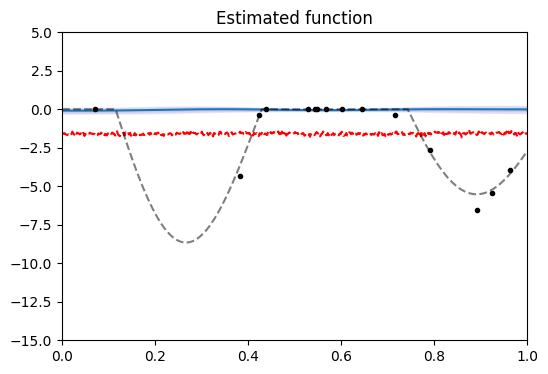

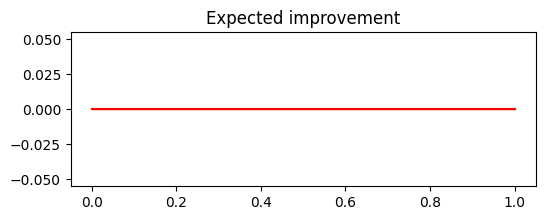

In [249]:
def plot_result(pred_samples, censored=False):
    if censored:
        c_pred = pred_samples > MAX_VALUE
        pred_samples[c_pred] = MAX_VALUE
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
      pred_median = np.median(pred_samples, axis=0)
      pred_quantiles = np.quantile(pred_samples, [0.025, 0.15, 0.85, 0.975], axis=0)

      plt.figure(figsize=(6, 4))
      plt.plot(domain, pred_median)

      plt.fill_between(domain, pred_quantiles[0], pred_quantiles[-1], alpha=0.1, color='#33c');
      plt.fill_between(domain, pred_quantiles[1], pred_quantiles[-2], alpha=0.1, color='#33c');
      plt.plot(domain, y_preds.sample_n(n=100).mean([0,1]).numpy(force=True), 'r--')

      plt.plot(x, y, 'k.');
      plt.plot(domain, noise_free_target(domain).clamp_max(MAX_VALUE), 'k--', alpha=0.5);
      plt.xlim(0, 1);
      plt.ylim(-15, 5);
      plt.title("Estimated function")

      plt.figure(figsize=(6, 2))
      plt.title("Expected improvement")
      EI =  -(pred_samples*(pred_samples < y.min()).float()).mean(0)
      plt.plot(domain, EI, 'r');
      plt.fill_between(domain, torch.zeros_like(domain), EI, color='r', alpha=0.5)

   # return f_covar, pred_samples

plot_result(pred_samples)

In [ ]:
# u,d = f_preds.confidence_region()
# plt.plot(domain, f_preds.loc.numpy(force=True))
# plt.fill_between(domain, u.numpy(force=True), d.numpy(force=True), alpha=0.1, color='#33c')
# plt.plot(domain, y_preds.sample_n(n=100).mean([0,1]).numpy(force=True), 'r--')
# plt.plot(x, y, 'k.');
# plt.plot(domain, noise_free_target(domain).clamp_max(MAX_VALUE), 'k--', alpha=0.5);

# MC Simulation

In [ ]:
from gpytorch.models import ApproximateGP # handles basic variational inference
from gpytorch.variational import CholeskyVariationalDistribution # distribution of the approximation q(f)
from gpytorch.variational import VariationalStrategy # use when larger sample - transform q(u) to q(f) over inducing points

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        # defines approximation
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points,
                                                   variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # defines the GP
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = GPModel(inducing_points=x[:,None])
# ElBO Likelihood
likelihood = CensoredGaussianLikelihood(low=-1000., high=MAX_VALUE)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [ ]:
print_module(model)

variational_strategy._variational_distribution.variational_mean (15,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
variational_strategy._variational_distribution.chol_variational_covar (15, 15)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
mean_module.constant                ()
0.0
covar_module.outputscale            ()
0

In [ ]:
num_epochs = 30000
pbar = tqdm.tqdm(range(num_epochs), position=0, leave=True)

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

mae_list = list()
loss_list = list()

for iter in pbar:
    optimizer.zero_grad();
    y_pred = model(x[:,None])
    loss = -mll(y_pred, y)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())

100%|██████████| 30000/30000 [06:42<00:00, 74.47it/s]


In [ ]:
print_module(likelihood)
print_module(model)

noise.noise                         (1,)
[1.1169327]
variational_strategy._variational_distribution.variational_mean (15,)
[ 1.48839581e+00  3.39540482e-01  7.76903391e-01  4.24102545e-01
 -1.54411960e+00  8.45990956e-01  6.40983999e-01 -9.73686039e-01
 -3.42777818e-01 -3.83375168e-01 -6.15274727e-01 -9.16507933e-03
  1.11113477e-03  1.34975985e-02  7.86047757e-01]
variational_strategy._variational_distribution.chol_variational_covar (15, 15)
[[ 2.2936320e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-3.4455344e-01  2.6246265e-01  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-3.0758467e-01 -2.2617280e-01  4.6102887e-01  0.0000000e+00
   0.0000000e+00  0.000

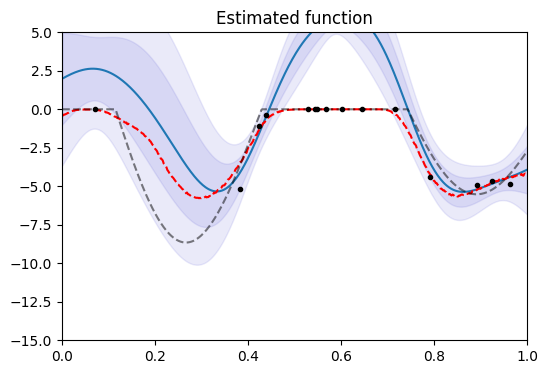

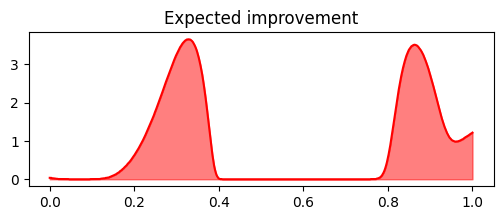

In [ ]:
model.eval()
likelihood.eval()

f_preds = model(domain[:,None])
y_preds = likelihood(f_preds)

f_mean = f_preds.loc
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

N_samples = 1000
breakpoints = torch.linspace(0, 1, N_samples+1)[:-1]
breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)

with torch.no_grad():
    pred_samples = torch.distributions.Normal(f_mean, f_var.sqrt()).icdf(breakpoints[:,None])

plot_result(pred_samples)